<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Meta-Learning_Projects/blob/main/MANN/Few_shot_learning_MANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import torch
import torchvision
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
import random
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("/content/data/")

In [4]:
import pdb

In [5]:
DS_PATH = "/content/data/omniglot-py/images_background"
IMG_SIZE = (28, 28)

In [6]:
dataset = torchvision.datasets.Omniglot(root="./data/", download=True, transform= torchvision.transforms.ToTensor())

Files already downloaded and verified


In [7]:
dataset

Dataset Omniglot
    Number of datapoints: 19280
    Root location: ./data/omniglot-py
    StandardTransform
Transform: ToTensor()

In [8]:
image = imageio.imread("/content/data/omniglot-py/images_background/Anglo-Saxon_Futhorc/character01/0296_01.png")
image.shape

<ipython-input-8-330856dd61f0>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("/content/data/omniglot-py/images_background/Anglo-Saxon_Futhorc/character01/0296_01.png")


(105, 105)

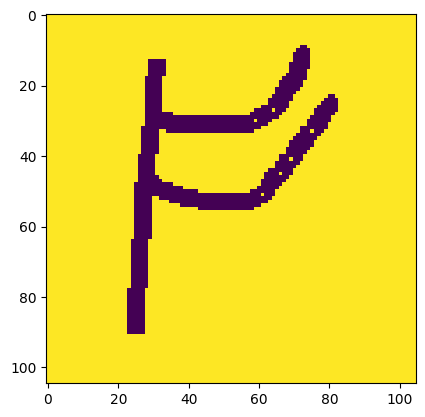

In [9]:
plt.imshow(image)

In [10]:
image

Array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

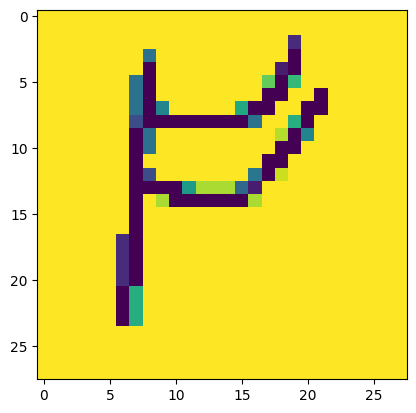

In [11]:
#img = imageio.imread(filename)
image = cv2.resize(image,IMG_SIZE)
plt.imshow(image)

In [12]:
def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths:  A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    sampler = lambda x: random.sample(x, nb_samples)

    t_img_lbl = [(lbl, os.path.join(path, image.decode('UTF-8')))
                  for lbl, path in zip(labels, paths)
                  for image in sampler(os.listdir(path))]
    if shuffle:
      random.shuffle(t_img_lbl)

    return t_img_lbl

In [13]:
def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    img = imageio.imread(filename)
    img = cv2.resize(img,IMG_SIZE)
    img = img.reshape([dim_input])
    img = img.astype(np.float32) / 255.0

    return img


In [14]:
class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, ds_path, img_size):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = ds_path
        self.img_size = img_size

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes


        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        np.random.seed(1)
        np.random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
                                         num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
                                          num_train + num_val:]

    def sample_batch(self, batch_type, batch_size, shuffle=True):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        B = batch_size
        N = self.num_classes
        K = self.num_samples_per_class
        I = self.dim_input

        all_image_batches = []
        all_label_batches = []

        # 0. Repeat for B batches
        for batch in range(B):
            # 1. Sample N different classes
            n_classes = np.random.choice(folders, N, replace=False)
            #print(n_classes)
            # 2. Sample and load K images
            # Shufle sampled images so
            tuples = get_images(n_classes, range(N), nb_samples=K, shuffle=False) # <! False?

            images = [image_file_to_array(im, I) for lb,im in tuples]
            images = np.stack(images)
            images = np.reshape(images, (N, K, I))

            #pprint.pprint(tuples)

            labels = np.asarray([lb for lb, im in tuples])
            labels = np.reshape(labels, (N, K))
            labels = np.eye(N)[labels]

            #pprint.pprint(tuples)
            #pprint.pprint(labels)

            labels = np.swapaxes(labels, 0, 1)
            images = np.swapaxes(images, 0, 1)
            #labels = np.swapaxes(labels, 0, 1)

            all_image_batches.append(images)
            all_label_batches.append(labels)

#             all_image_batches[batch, :, :, :] = images# np.reshape(images, (K, N, I))
#             all_label_batches[batch, :, :, :] = labels#np.swapaxes(np.swapaxes(labels, 0,1), 1,2)
        all_image_batches = np.stack(all_image_batches)
        all_label_batches = np.stack(all_label_batches)
        # print(">> ", all_image_batches.shape)
        # print(">> ", all_label_batches.shape)
            #############################
        return all_image_batches, all_label_batches

In [15]:
num_classes=5
num_samples_per_class=3

data = DataGenerator(num_classes, num_samples_per_class, DS_PATH, IMG_SIZE)

images, labels = data.sample_batch('train', batch_size=2, shuffle=False)
print("Batch of images of shape:", images.shape)
print("Batch of labels of shape:", labels.shape)
type(images), type(labels)

Batch of images of shape: (2, 3, 5, 784)
Batch of labels of shape: (2, 3, 5, 5)


<ipython-input-13-70d8abfc66d3>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filename)


(numpy.ndarray, numpy.ndarray)

In [16]:
hidden_size = 128
num_layers = 1
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
class MANN(nn.Module):
  def __init__(self, num_classes, samples_per_class):
    super().__init__()
    self.num_classes = num_classes
    self.samples_per_class = samples_per_class
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    input_size = num_classes + np.prod(IMG_SIZE)
    self.layer1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.layer2 = nn.LSTM(hidden_size, num_classes, batch_first=True)

  def forward(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        # [:,:,:,784],[:,:,:,5] => [:,:,:,789]
        B, K, N, I = input_images.shape
        # Zero last N example, corresponding to the K+1 sample
        # Note the '-1'+':,' so num of dimensions keeps equal
        in_zero = torch.cat([input_labels[:, :-1, :, :], torch.zeros(B,1,N,N)], dim=1)
        input_concat = torch.cat([input_images, in_zero], dim=3)
        input_concat = torch.reshape(input_concat, [-1, K*N, N + 28*28])

        # Set initial hidden states (and cell states for LSTM)
        h0_l1 = torch.zeros(1, input_images.size(0), self.hidden_size).to(device)
        c0_l1 = torch.zeros(1, input_images.size(0), self.hidden_size).to(device)

        h0_l2 = torch.zeros(1, input_images.size(0), self.num_classes).to(device)
        c0_l2 = torch.zeros(1, input_images.size(0), self.num_classes).to(device)

        out, _ = self.layer1(input_concat.float(), (h0_l1, c0_l1))

        out, _ = self.layer2(out, (h0_l2, c0_l2))
        out = torch.reshape(out, [-1, K, N, N])
        #############################
        return out




In [25]:
def run_experiment(num_classes=2, num_samples=1, meta_batch_size=1, epochs=500, verbose=True):
  model = MANN(num_classes, num_samples + 1)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  running_loss = 0.0
  running_accuracy = 0.0

  #writer.add_graph(model, data.sample_batch(batch_type='train', batch_size=meta_batch_size))

  for epoch in range(epochs):
    i, l = data.sample_batch(batch_type='train', batch_size=meta_batch_size)
    i = torch.tensor(i)
    l = torch.tensor(l)
    preds = model(i, l)

    loss = criterion(preds[:,-1:,:,:], l[:,-1:,:,:])
    running_loss += loss.item()

    preds = preds[:, -1, :, :].argmax(2)
    l = l[:, -1, :, :].argmax(2)
    running_accuracy += (1.0 * (preds == l)).mean()

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
      accuracy = running_accuracy / (100 * preds.size(0) * preds.size(1))
      print (f'Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f} Accuracy: {accuracy}')
      writer.add_scalar('training loss', running_loss / 100, epoch)
      writer.add_scalar('accuracy', accuracy, epoch)
      running_accuracy = 0.0
      running_loss = 0.0

    writer.close()



In [ ]:
# Number of classes used in classification (e.g. 5-way classification).
num_classes = 5

# Number of examples used for inner gradient update (K for K-shot learning)
num_samples = 1

# Number of N-way classification tasks per batch
meta_batch_size = 4

run_experiment(num_classes=5, num_samples=1, meta_batch_size=4, epochs=1000)